<a href="https://colab.research.google.com/github/DongUk-Park/RnD/blob/main/GNN/Recommendation_LightGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

## Data Load & Explore

In [7]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
import pandas as pd

ratings = pd.read_csv('Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('Books.csv', sep=';', encoding='latin-1', error_bad_lines=False)

<ipython-input-8-1828c9003b51>:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('Users.csv', sep=';', encoding='latin-1')
<ipython-input-8-1828c9003b51>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('Books.csv', sep=';', encoding='latin-1', error_bad_lines=False)


In [9]:
ratings

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


<Axes: xlabel='Rating', ylabel='count'>

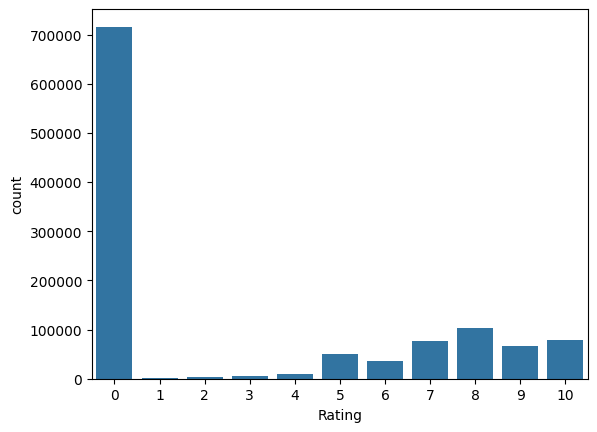

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=ratings['Rating'])

In [11]:
print(len(ratings['User-ID'].unique()))
print(len(ratings['ISBN'].unique()))

105283
340556


Text(0, 0.5, 'Count')

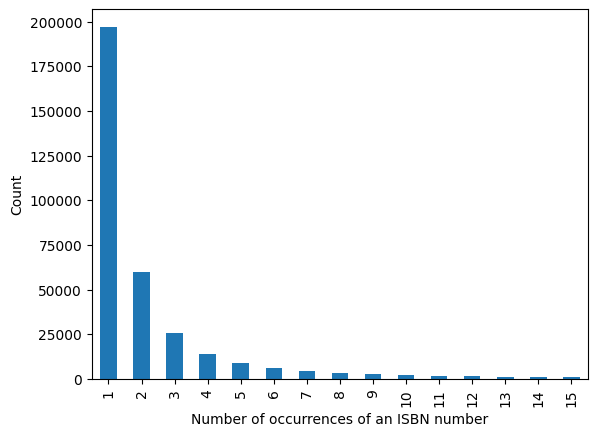

In [12]:
isbn_counts = ratings.groupby('ISBN').size()
count_occurrences = isbn_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of an ISBN number")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

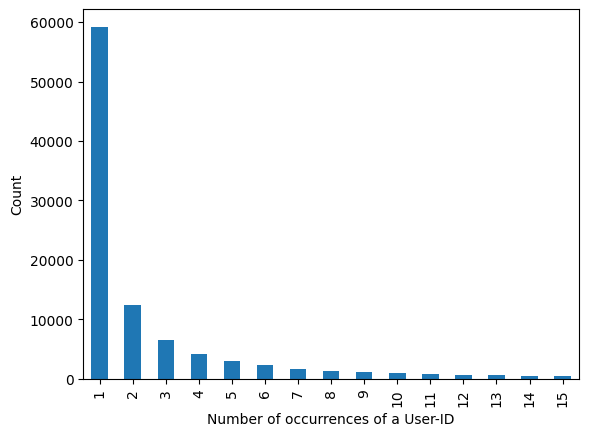

In [13]:
userid_counts = ratings.groupby('User-ID').size()
count_occurrences = userid_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of a User-ID")
plt.ylabel("Count")

## Data Preprocessing

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [15]:
df = pd.read_csv('Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('Books.csv', sep=';', encoding='latin-1', error_bad_lines=False)

# Preprocessing
# ISBN 칼럼에 있는 책들 중 Books.csv에 없는 책은 삭제, User-ID 또한 User.csv에 없는 User는 삭제
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k highest ratings
df = df[df['Rating'] >= 8].iloc[:100000]

print(df, users, books)

<ipython-input-15-f9811fd6129a>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('Users.csv', sep=';', encoding='latin-1')
<ipython-input-15-f9811fd6129a>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('Books.csv', sep=';', encoding='latin-1', error_bad_lines=False)


        User-ID        ISBN  Rating
9586         12  1879384493      10
9591         16  0345402871       9
9607         26  0446310786      10
9608         26  0449005615       9
9609         32  0060168013       8
...         ...         ...     ...
480298   114601  0743419049      10
480303   114604  0618002219       9
480314   114611  0445409134       8
480315   114611  0446313033       8
480317   114611  0553276743       8

[100000 rows x 3 columns]        User-ID  Age
0            1  NaN
1            2   18
2            3  NaN
3            4   17
4            5  NaN
...        ...  ...
278854  278854  NaN
278855  278855   50
278856  278856  NaN
278857  278857  NaN
278858  278858  NaN

[278859 rows x 2 columns]               ISBN                                              Title  \
0       0195153448                                Classical Mythology   
1       0002005018                                       Clara Callan   
2       0060973129                               Decisi

In [16]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

print(num_users, num_items, num_total)

19557 56913 76470


In [17]:
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [18]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [19]:
def sample_mini_batch(edge_index):
    # BATCH_SIZE만큼의 랜덤 엣지 인덱스를 가져옴
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # 주어진 positive edge에 대해 negative edge 생성하고 추가함
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)

    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]

    return user_index, pos_item_index, neg_item_index

Implement LightGCN

In [20]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        # 임베딩 초기화
        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        # 유저 임베딩 아래에 아이템 임베딩을 이어붙여 한번에 계산
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb] # emb shape : (users + items) x emb

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb) # 최종적으로 초기 emb 1개 + 각각의 conv layer를 통과한 emb 3개

        # stack으로 만든 (users + items) x 4 x emb 행렬에서 1번째 dim(4)를 기준으로 평균을 낸 (users + items) x emb 생성
        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])
        # .weight를 붙여 초기 상태의 임베딩도 반환함
        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

Loss

In [21]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    #bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    # return에 (-)를 붙였기 때문에 최적화 과정에서 loss가 작아지기 위해선 pos-neg_ratings가 커져야함
    # -> pos rating이 커지고, neg rating이 작아지는 방향으로 학습
    return -bpr_loss + reg_loss

In [22]:
# 각 사용자가 상호작용한 아이템의 리스트를 만들어내는 함수
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [23]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices): # train에서 사용한 edge_index들은 제외
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [25]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

def compute_ndcg_at_k(items_ground_truth, items_predicted):
    # items_ground_truth: 실제 선호 리스트, items_predicted : 추천 아이템 리스트

    # 실제 선호 아이템에 대한 행렬 생성(선호 : 1, 아니면 : 0), relevance 역할
    test_matrix = np.zeros((len(items_predicted), K))
    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1

    # IDCG 계산
    max_r = test_matrix # 이상적인 상황에서의 행렬
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1) # 사용자별로 이상적인 상황에서의 DCG 값 계산
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2))) # DCG 값 계산
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1. # idcg가 0인경우, 0으로 나누는것을 방지
    ndcg = dcg / idcg # NDCG 계산
    ndcg[np.isnan(ndcg)] = 0. # NAN값은 0으로 처리

    return np.mean(ndcg)

# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):
    # user_num x item_num, 사용자별 아이템 평가점수 행렬 계산
    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    # 평가 과정에서 제외할 user-item 쌍을 식별, 매우 낮은값(-1024)로 설정하여 추천에서 제외
    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [30]:
%%time
n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(21):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index) # 전체 유저의 임베딩을 얻음
        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)
        # train시킨 edge_index에 포함하는 임베딩만 추출(BatchSize(1024)개)
        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

        # 미니배치의 pos,neg 아이템의 임베딩을 추출함
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])
print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Epoch 0 | Train loss: 0.67997 | Val loss: 0.72589 | Val recall@20: 0.01828 | Val ndcg@20: 0.00912
Epoch 5 | Train loss: 0.67014 | Val loss: 0.77532 | Val recall@20: 0.01560 | Val ndcg@20: 0.00764
Epoch 10 | Train loss: 0.64765 | Val loss: 0.80447 | Val recall@20: 0.01088 | Val ndcg@20: 0.00569
Epoch 15 | Train loss: 0.65036 | Val loss: 0.82269 | Val recall@20: 0.01112 | Val ndcg@20: 0.00522
Epoch 20 | Train loss: 0.65238 | Val loss: 0.83845 | Val recall@20: 0.01061 | Val ndcg@20: 0.00509
Test loss: 0.83567 | Test recall@20: 0.00704 | Test ndcg@20: 0.00334
CPU times: user 13min 41s, sys: 3min 35s, total: 17min 17s
Wall time: 17min 23s


Evaluation

In [31]:
import numpy as np
print(np.arange(2, 20 + 2))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


Recommending Books

In [32]:
bookid_title = pd.Series(books['Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Author'].values, index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)

from PIL import Image
import requests

def recommend(user_id, num_recs):
    # 추천받고자 하는 user_id, 추천 받을 개수를 받아옴
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user] # 해당 유저의 임베딩을 가져옴
    ratings = model.emb_items.weight @ emb_user # 유저 임베딩으로 아이템별 점수 측정

    values, indices = torch.topk(ratings, k=100) # 점수가 높은 아이템 100개 추출

    # 100개 중 user가 상호작용한 book들만 ids에 저장,
    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    # ids에 있는 책들의 ISBN을 가져옴
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    # 위에서 가져온 ISBN으로 제목과 저자를 가져옴
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite books from user n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    # # 100개 중 user가 상호작용하지 않은 book들만 ids에 저장, 이후 위와 동일
    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')


    # headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    # fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
    # fig.patch.set_alpha(0)
    # for i, title in enumerate(titles):
    #     # 책의 이미지 출력
    #     url = books.loc[books['Title'] == title]['Image-URL-L'][:1].values[0]
    #     img = Image.open(requests.get(url, stream=True, headers=headers).raw)
    #     rating = df.loc[df['ISBN'] == books.loc[books['Title'] == title]['ISBN'][:1].values[0]]['Rating'].mean()
    #     axs[i].axis("off")
    #     axs[i].imshow(img)
    #     axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)

#print(user_mapping)

recommend(114611, 5)

Favorite books from user n°114611:

Recommended books for user n°114611
- Earth and Its Peoples: A Global History Since 1500, by Richard W. Bulliet
- The Cat's Meow (Paranormal Romance), by Victoria Alexander
- The Bachman Books: Rage, the Long Walk, Roadwork, the Running Man, by Stephen King
- Was This Man a Genius?: Talks With Andy Kaufman, by Julie Hecht
- Recipes For Easy Living, by Curtiss Ann Matlock
